In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Project/2023/KT_ETRI

/content/drive/MyDrive/Project/2023/KT_ETRI


In [ ]:
import pandas as pd
import numpy as np

### 데이터 로드

분야1_군집화.ipynb 파일에서 전처리 완료한 데이터 불러오기

In [ ]:
train_df = pd.read_csv('Q1_data/Q1_train_pre.csv')
test_df = pd.read_csv('Q1_data/Q1_test_pre.csv')
train_df.head()

,datetime,ru_id,scgfailratio,erabaddatt,erabaddratio,endcaddatt,endcaddratio,endcmodbymenbatt,endcmodbymenbratio,endcmodbysgnbatt,...,airmacdlbyte,bler_ul,bler_dl,rachpreamblea,nummsg3,attpaging,rssipathavg,dlreceivedcqiavg,endcrelbymenb,uenomax
0,2023-05-19 00:00:00,BaseStationA,0.0,9,100.0,5,100.0,2,100.0,7,...,306.0,23.6,6.4,17.0,11.0,2083.0,-92.8,11.2,3,1
1,2023-05-19 00:05:00,BaseStationA,8.3,12,100.0,9,100.0,0,0.0,15,...,9385.0,15.6,2.4,19.0,15.0,1936.0,-92.8,10.7,11,2
2,2023-05-19 00:10:00,BaseStationA,0.0,9,100.0,8,100.0,4,100.0,11,...,19534.0,17.5,9.9,28.0,23.0,1874.0,-92.7,10.7,5,3
3,2023-05-19 00:15:00,BaseStationA,0.0,11,100.0,10,100.0,0,0.0,8,...,2260.0,19.9,5.0,16.0,14.0,1815.0,-92.6,9.4,8,2
4,2023-05-19 00:20:00,BaseStationA,0.0,9,100.0,8,100.0,0,0.0,9,...,446.0,17.1,0.6,14.0,10.0,1784.0,-92.8,9.6,8,2


In [ ]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

군집화 결과에서 B, C, D, J가 같은 군집으로 분류되었으므로, C와 D를 이용해서 모델링 진행

### 데이터 분리

In [ ]:
# Station별로 분리(B, C, D, J만 필요함)
StationB = test_df[test_df['ru_id'] == 'BaseStationB']
StationC = train_df[train_df['ru_id'] == 'BaseStationC']
StationD = train_df[train_df['ru_id'] == 'BaseStationD']
StationJ = test_df[test_df['ru_id'] == 'BaseStationJ']

In [ ]:
StationB.reset_index(drop = True, inplace = True)
StationC.reset_index(drop = True, inplace = True)
StationD.reset_index(drop = True, inplace = True)
StationJ.reset_index(drop = True, inplace = True)

# LSTM

In [ ]:
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 710.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [ ]:
import os
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

In [ ]:
torch.__version__

'1.13.0+cu116'

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

## 함수들 정의하기

In [ ]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

In [ ]:
## LSTM 네트워크
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim).to(device),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim).to(device))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [ ]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.L1Loss() # 평가기준 : MAE
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, (x_train, y_train) in enumerate(train_df):

            x_train = x_train.to(device)
            y_train = y_train.to(device)

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')

                break

    return model.eval(), train_hist

## StationC 모델링

In [ ]:
# 하이퍼파라미터
seq_length = 24
batch_size = 128

data_dim = 34    # 입력 column
hidden_dim = 4  # 은닉층
output_dim = 1   # 출력층
layers = 2

learning_rate = 0.001
nb_epochs = 500

In [ ]:
C_df = StationC.set_index('datetime')
C_df = C_df.iloc[:, 1:]

In [ ]:
# train : test = 7 : 3 분리
train_size = int(len(C_df) * 0.7)
train_set = C_df[0:train_size]
test_set = C_df[(train_size - seq_length):]

In [ ]:
# scaling
Cscaler_x = StandardScaler()
Cscaler_x.fit(train_set.iloc[:, :-1])

train_set_scale = train_set.copy()
test_set_scale = test_set.copy()

train_set_scale.iloc[:, :-1] = Cscaler_x.transform(train_set.iloc[:, :-1])
test_set_scale.iloc[:, :-1] = Cscaler_x.transform(test_set.iloc[:, :-1])

Cscaler_y = StandardScaler()
Cscaler_y.fit(train_set.iloc[:, [-1]])

train_set_scale.iloc[:, -1] = Cscaler_y.transform(train_set.iloc[:, [-1]])
test_set_scale.iloc[:, -1] = Cscaler_y.transform(test_set.iloc[:, [-1]])

### 데이터셋 생성 및 tensor로 변환

In [ ]:
trainX, trainY = build_dataset(np.array(train_set_scale), seq_length)
testX, testY = build_dataset(np.array(test_set_scale), seq_length)

In [ ]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size = batch_size,
                        shuffle = False,
                        drop_last = True)

### 모델 학습

In [ ]:
net = Net(data_dim, hidden_dim, seq_length, output_dim, layers).to(device)
model_C, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.7981
Epoch: 0020 train loss : 0.4870
Epoch: 0040 train loss : 0.4753
Epoch: 0060 train loss : 0.4713
Epoch: 0080 train loss : 0.4685
Epoch: 0100 train loss : 0.4665
Epoch: 0120 train loss : 0.4647
Epoch: 0140 train loss : 0.4630
Epoch: 0160 train loss : 0.4615
Epoch: 0180 train loss : 0.4605
Epoch: 0200 train loss : 0.4595
Epoch: 0220 train loss : 0.4583
Epoch: 0240 train loss : 0.4576
Epoch: 0260 train loss : 0.4570
Epoch: 0280 train loss : 0.4562
Epoch: 0300 train loss : 0.4558
Epoch: 0320 train loss : 0.4551
Epoch: 0340 train loss : 0.4547
Epoch: 0360 train loss : 0.4541
Epoch: 0380 train loss : 0.4537

 Early Stopping


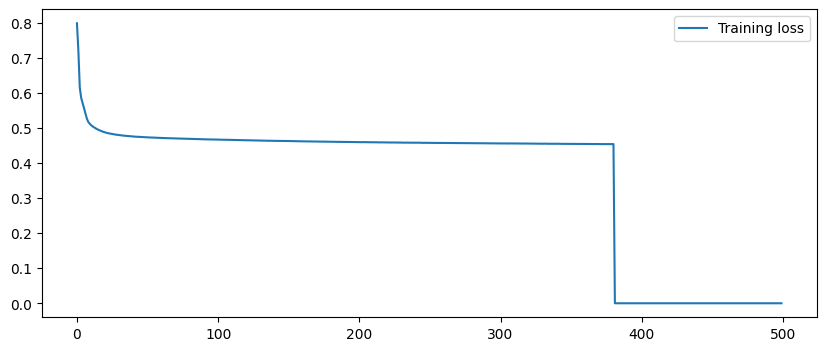

In [ ]:
# epoch별 loss
fig = plt.figure(figsize = (10, 4))
plt.plot(train_hist, label = "Training loss")
plt.legend()
plt.show()

### test 데이터셋으로 MAE 계산

In [ ]:
# 예측 테스트
with torch.no_grad(): # gradient 계산 수행 x -> 메모리 사용안하도록
    pred = []
    for pr in range(len(testX_tensor)):

        model_C.reset_hidden_state() # 순환 레이어의 은닉 상태 초기화

        predicted = model_C(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # [INVERSE] 모델이 예측한 값을 다시 스케일 역변환하여 원래 스케일로 되돌림
    pred_inverse = Cscaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = Cscaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  0.8895269361243001


## StationD 모델링

In [ ]:
# 하이퍼파라미터
seq_length = 24
batch_size = 128

data_dim = 34    # 입력 column
hidden_dim = 4  # 은닉층
output_dim = 1   # 출력층
layers = 2

learning_rate = 0.001
nb_epochs = 1000

In [ ]:
D_df = StationD.set_index('datetime')
D_df = D_df.iloc[:, 1:]

In [ ]:
# train : test = 7 : 3 분리
train_size = int(len(D_df) * 0.7)
train_set = D_df[0:train_size]
test_set = D_df[(train_size - seq_length):]

In [ ]:
# scaling
Dscaler_x = StandardScaler()
Dscaler_x.fit(train_set.iloc[:, :-1])

train_set_scale = train_set.copy()
test_set_scale = test_set.copy()

train_set_scale.iloc[:, :-1] = Dscaler_x.transform(train_set.iloc[:, :-1])
test_set_scale.iloc[:, :-1] = Dscaler_x.transform(test_set.iloc[:, :-1])

Dscaler_y = StandardScaler()
Dscaler_y.fit(train_set.iloc[:, [-1]])

train_set_scale.iloc[:, -1] = Dscaler_y.transform(train_set.iloc[:, [-1]])
test_set_scale.iloc[:, -1] = Dscaler_y.transform(test_set.iloc[:, [-1]])

### 데이터셋 생성 및 tensor로 변환

In [ ]:
trainX, trainY = build_dataset(np.array(train_set_scale), seq_length)
testX, testY = build_dataset(np.array(test_set_scale), seq_length)

In [ ]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size = batch_size,
                        shuffle = False,
                        drop_last = True)

### 모델 학습

In [ ]:
net = Net(data_dim, hidden_dim, seq_length, output_dim, layers).to(device)
model_D, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.8645
Epoch: 0020 train loss : 0.5547
Epoch: 0040 train loss : 0.5406
Epoch: 0060 train loss : 0.5344
Epoch: 0080 train loss : 0.5303
Epoch: 0100 train loss : 0.5276
Epoch: 0120 train loss : 0.5250
Epoch: 0140 train loss : 0.5228
Epoch: 0160 train loss : 0.5209
Epoch: 0180 train loss : 0.5192
Epoch: 0200 train loss : 0.5180
Epoch: 0220 train loss : 0.5165
Epoch: 0240 train loss : 0.5151
Epoch: 0260 train loss : 0.5139
Epoch: 0280 train loss : 0.5125
Epoch: 0300 train loss : 0.5110
Epoch: 0320 train loss : 0.5097
Epoch: 0340 train loss : 0.5081
Epoch: 0360 train loss : 0.5069
Epoch: 0380 train loss : 0.5056
Epoch: 0400 train loss : 0.5044
Epoch: 0420 train loss : 0.5031
Epoch: 0440 train loss : 0.5022
Epoch: 0460 train loss : 0.5013
Epoch: 0480 train loss : 0.5006
Epoch: 0500 train loss : 0.4993
Epoch: 0520 train loss : 0.4985

 Early Stopping


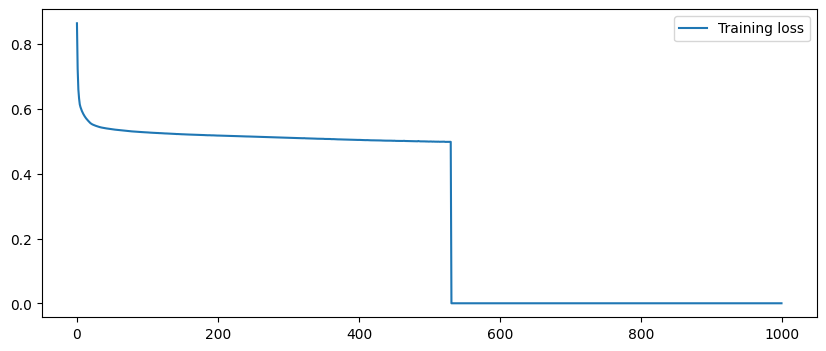

In [ ]:
# epoch별 loss
fig = plt.figure(figsize = (10, 4))
plt.plot(train_hist, label = "Training loss")
plt.legend()
plt.show()

### test 데이터셋(train/test로 나눈 것)으로 MAE 계산

In [ ]:
# 예측 테스트
with torch.no_grad(): # gradient 계산 수행 x -> 메모리 사용안하도록
    pred = []
    for pr in range(len(testX_tensor)):

        model_D.reset_hidden_state() # 순환 레이어의 은닉 상태 초기화

        predicted = model_D(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # [INVERSE] 모델이 예측한 값을 다시 스케일 역변환하여 원래 스케일로 되돌림
    pred_inverse = Dscaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = Dscaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  0.8338044758648075


- 하이퍼파라미터 변경해가면서 해보기
  - hidden layer 개수 늘리고, hidden dim 줄여서 해보기

## test 데이터(y값 없는거) 전처리 및 예측

In [ ]:
label_sample = pd.read_csv('Q1_data/Q1_label_sample.csv')
label_sample.head()

,datetime,BaseStationB,BaseStationJ
0,2023-05-19 00:00:00,0,0
1,2023-05-19 00:05:00,0,0
2,2023-05-19 00:10:00,0,0
3,2023-05-19 00:15:00,0,0
4,2023-05-19 00:20:00,0,0


### StationB 예측

##### C 모델로 예측

In [ ]:
B_df = StationB.set_index('datetime')
B_df = B_df.iloc[:, 1:]

# StationB에 uenomax 추가(값 다 0으로)
B_df['uenomax'] = 0

In [ ]:
# 학습 데이터에서 마지막 행 가져오기 -> 학습데이터가 테스트 데이터의 이전 시간이 아닌데 이렇게 해도 되나...?
# 근데 이렇게 안하면 seq_length만큼 데이터 빠지는거 어떻게 해결해주지?
last_train_data = C_df.iloc[len(C_df)-seq_length:, :]
B_df = pd.concat((last_train_data, B_df)).reset_index(drop = True)

In [ ]:
# scaling
B_scale = B_df.copy()
B_scale.iloc[:, :-1] = Cscaler_x.transform(B_scale.iloc[:, :-1])

In [ ]:
B_scale.shape

(17205, 34)

In [ ]:
BtestX, BtestY = build_dataset(np.array(B_scale), seq_length)

In [ ]:
# 텐서로 변환
testX_tensor = torch.FloatTensor(BtestX)
testY_tensor = torch.FloatTensor(BtestY)

In [ ]:
# 예측값 출력
with torch.no_grad(): # gradient 계산 수행 x -> 메모리 사용안하도록
    pred_C = []
    for pr in range(len(testX_tensor)):

        model_C.reset_hidden_state() # 순환 레이어의 은닉 상태 초기화

        predicted = model_C(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred_C.append(predicted)

    # [INVERSE] 모델이 예측한 값을 다시 스케일 역변환하여 원래 스케일로 되돌림
    pred_C_inverse = Cscaler_y.inverse_transform(np.array(pred_C).reshape(-1, 1))

In [ ]:
print(pred_C_inverse.shape)
pred_C_inverse

(17181, 1)


array([[4.8522681 ],
       [4.14984607],
       [4.00043907],
       ...,
       [2.56956306],
       [2.71522168],
       [2.47496811]])

##### D 모델로 예측

In [ ]:
B_df = StationB.set_index('datetime')
B_df = B_df.iloc[:, 1:]

# StationB에 uenomax 추가(값 다 0으로)
B_df['uenomax'] = 0

In [ ]:
last_train_data = D_df.iloc[len(D_df)-seq_length:, :]
B_df = pd.concat((last_train_data, B_df)).reset_index(drop = True)

In [ ]:
# scaling
B_scale = B_df.copy()
B_scale.iloc[:, :-1] = Dscaler_x.transform(B_scale.iloc[:, :-1])

In [ ]:
B_scale.shape

(17205, 34)

In [ ]:
BtestX, BtestY = build_dataset(np.array(B_scale), seq_length)

In [ ]:
# 텐서로 변환
testX_tensor = torch.FloatTensor(BtestX)
testY_tensor = torch.FloatTensor(BtestY)

In [ ]:
# 예측값 출력
with torch.no_grad(): # gradient 계산 수행 x -> 메모리 사용안하도록
    pred_D = []
    for pr in range(len(testX_tensor)):

        model_D.reset_hidden_state() # 순환 레이어의 은닉 상태 초기화

        predicted = model_D(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred_D.append(predicted)

    # [INVERSE] 모델이 예측한 값을 다시 스케일 역변환하여 원래 스케일로 되돌림
    pred_D_inverse = Dscaler_y.inverse_transform(np.array(pred_D).reshape(-1, 1))

제출할때 3.43 이런식으로 소수점으로 나오면 그냥 제출? 아니면 정수로 바꿔서 제출?  
일단은 그냥 제출하는걸로 해볼게

In [ ]:
print(pred_D_inverse.shape)
pred_D_inverse

(17181, 1)


array([[3.96905034],
       [2.99804068],
       [3.29285486],
       ...,
       [2.992185  ],
       [3.29208829],
       [2.35813081]])

일단 모델 C, D로 예측한 결과의 평균을 사용하는걸로 해볼게

In [ ]:
label_sample['BaseStationB'] = (pred_C_inverse + pred_D_inverse) / 2

### StationJ 예측

##### C 모델로 예측

In [ ]:
J_df = StationJ.set_index('datetime')
J_df = J_df.iloc[:, 1:]

# StationJ에 uenomax 추가(값 다 0으로)
J_df['uenomax'] = 0

In [ ]:
# 학습 데이터에서 마지막 행 가져오기 -> 학습데이터가 테스트 데이터의 이전 시간이 아닌데 이렇게 해도 되나...?
# 근데 이렇게 안하면 seq_length만큼 데이터 빠지는거 어떻게 해결해주지?
last_train_data = C_df.iloc[len(C_df)-seq_length:, :]
J_df = pd.concat((last_train_data, J_df)).reset_index(drop = True)

In [ ]:
# scaling
J_scale = J_df.copy()
J_scale.iloc[:, :-1] = Cscaler_x.transform(J_scale.iloc[:, :-1])

In [ ]:
J_scale.shape

(17205, 34)

In [ ]:
JtestX, JtestY = build_dataset(np.array(J_scale), seq_length)

In [ ]:
# 텐서로 변환
testX_tensor = torch.FloatTensor(JtestX)
testY_tensor = torch.FloatTensor(JtestY)

In [ ]:
# 예측값 출력
with torch.no_grad(): # gradient 계산 수행 x -> 메모리 사용안하도록
    pred_C = []
    for pr in range(len(testX_tensor)):

        model_C.reset_hidden_state() # 순환 레이어의 은닉 상태 초기화

        predicted = model_C(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred_C.append(predicted)

    # [INVERSE] 모델이 예측한 값을 다시 스케일 역변환하여 원래 스케일로 되돌림
    pred_C_inverse = Cscaler_y.inverse_transform(np.array(pred_C).reshape(-1, 1))

In [ ]:
print(pred_C_inverse.shape)
pred_C_inverse

(17181, 1)


array([[4.8522681 ],
       [4.29233673],
       [4.15290275],
       ...,
       [3.69711212],
       [2.76619007],
       [4.06168436]])

##### D 모델로 예측

In [ ]:
J_df = StationJ.set_index('datetime')
J_df = J_df.iloc[:, 1:]

# StationB, StationJ에 uenomax 추가(값 다 0으로)
J_df['uenomax'] = 0

In [ ]:
last_train_data = J_df.iloc[len(D_df)-seq_length:, :]
J_df = pd.concat((last_train_data, J_df)).reset_index(drop = True)

In [ ]:
# scaling
J_scale = J_df.copy()
J_scale.iloc[:, :-1] = Dscaler_x.transform(J_scale.iloc[:, :-1])

In [ ]:
J_scale.shape

(17205, 34)

In [ ]:
JtestX, JtestY = build_dataset(np.array(J_scale), seq_length)

In [ ]:
# 텐서로 변환
testX_tensor = torch.FloatTensor(JtestX)
testY_tensor = torch.FloatTensor(JtestY)

In [ ]:
# 예측값 출력
with torch.no_grad(): # gradient 계산 수행 x -> 메모리 사용안하도록
    pred_D = []
    for pr in range(len(testX_tensor)):

        model_D.reset_hidden_state() # 순환 레이어의 은닉 상태 초기화

        predicted = model_D(torch.unsqueeze(testX_tensor[pr].to(device), 0))
        predicted = torch.flatten(predicted).item()
        pred_D.append(predicted)

    # [INVERSE] 모델이 예측한 값을 다시 스케일 역변환하여 원래 스케일로 되돌림
    pred_D_inverse = Dscaler_y.inverse_transform(np.array(pred_D).reshape(-1, 1))

제출할때 3.43 이런식으로 소수점으로 나오면 그냥 제출? 아니면 정수로 바꿔서 제출?  
일단은 그냥 제출하는걸로 해볼게

In [ ]:
print(pred_D_inverse.shape)
pred_D_inverse

(17181, 1)


array([[3.01509366],
       [2.86783183],
       [2.25115157],
       ...,
       [2.01373361],
       [1.99162459],
       [2.70394432]])

일단 모델 C, D로 예측한 결과의 평균을 사용하는걸로 해볼게

In [ ]:
label_sample['BaseStationJ'] = (pred_C_inverse + pred_D_inverse) / 2

In [ ]:
label_sample

,datetime,BaseStationB,BaseStationJ
0,2023-05-19 00:00:00,4.410659,3.933681
1,2023-05-19 00:05:00,3.573943,3.580084
2,2023-05-19 00:10:00,3.646647,3.202027
3,2023-05-19 00:15:00,3.202654,3.342582
4,2023-05-19 00:20:00,3.371055,3.212986
...,...,...,...
17176,2023-07-17 15:30:00,2.950534,2.906046
17177,2023-07-17 15:35:00,3.245972,3.245500
17178,2023-07-17 15:40:00,2.780874,2.855423
17179,2023-07-17 15:45:00,3.003655,2.378907


In [ ]:
label_sample.to_csv('Q1_data/submission.csv', index = False)

# 해결해야할 부분

1. LSTM에서 배치 사이즈, 은닉층 개수 등 바꿔가면서 해보기
2. 다른 모델도 해보기
3. 제출 시 소수점 그대로 제출할지 아니면 정수로 바꿔서 제출할지
4. B,J에 대한 예측값 도출할 때, seq_length만큼 학습 데이터에서 마지막 행을 가져오는 코드로 짰는데, 학습 데이터가 테스트 데이터의 이전 시간이 아닌데 이렇게 해도 되는지  
  - 근데 이렇게 안하면 seq_length만큼 데이터 빠지는거 어떻게 해결해주지?